In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [57]:
def convert_to_sec(args):
    largs = list(args)
    return 3600 * largs[0] + 60 * largs[1] + largs[2]

In [58]:
def preprocess(date : str):
    # 읽기
    useful_col = [2, 11]
    bus_name = "5511"

    data = pd.read_csv("data\\" + bus_name + "_" + date + ".csv")
    
    # column 따두기 및 맨 윗줄 지우기
    columns = data.iloc[0, slice(2, useful_col[1])]
    columns[0] = "환산시각(초)"
    columns[-1] = "버스 환산시각(초)"
    data = data.drop(0, axis=0)

    # 시각 빈곳 채우기
    for i in range(3):
        for j in range(data.shape[0]):
            if data.iloc[j, i] is np.NaN:
                data.iloc[j, i] = data.iloc[j - 1, i]

    # 아랫쪽 빈곳 지우기
    key = [row + 1 for row in range(data.shape[0]) if all(data.iloc[row, slice(0, useful_col[1] - 4)].isnull())]
    data = data.drop(key, axis=0)
    
    # 시간 변환하기 및 column 세팅하기
    for i in range(data.shape[0]):
        data.iloc[i, 2] = convert_to_sec(map(int, data.iloc[i, 0:3]))
        if all(data.iloc[i, slice(useful_col[1] - 1, useful_col[1] + 2)].notna()):
            data.iloc[i, useful_col[1] - 1] = convert_to_sec(map(int, data.iloc[i, slice(useful_col[1] - 1, useful_col[1] + 2)]))
    data = data.iloc[:, slice(2, useful_col[1])]
    data.columns = columns
    data = data.drop(["버스 번호"], axis=1)

    # 남아 있는 사람 계산하기
    for i in range(1, data.shape[0]):
        tmp = 0
        for j in range(0, useful_col[1] - 6):
            try: 
                if j == 0: tmp += int(data.iloc[i, j + 1])
                else: tmp -= int(data.iloc[i, j + 1])
            except:
                pass

        data.iloc[i, -2] = int(data.iloc[i - 1, -2]) + tmp

    return data

In [59]:
def draw(name, data):
    plt.figure()
    # sns.kdeplot(data)
    sns.histplot(data)
    plt.savefig("graphs\\" + name[0] + "_" + name[1] + ".png")

In [60]:
def return_time_interval(time, time_intv_dist=600):
    interval_num = int((time - 18000) / time_intv_dist)
    if interval_num < 6:
        return f"5:{interval_num}0 ~ 5:{interval_num}9"
    else:
        return f"6:{interval_num - 6}0 ~ 6:{interval_num - 6}9"

In [61]:
def retrieve():
    data = pd.read_csv("data\\5511_시간대_탈사람_남은사람_시간별 구분.csv")
    bus_period = []
    for j in range(1, data.shape[1], 3):
        time_tmp = 99999
        for i in range(data.shape[0]):
            if data.iloc[i, :].notna()[j + 1]:
                time_str = str(data.iloc[i, 0])
                time = convert_to_sec([int(time_str[0:2]), int(time_str[2:4]), 0])
                if time_tmp > time:
                    time_tmp = time
                else:
                    bus_period.append(time - time_tmp)
                    time_tmp = time

    return bus_period

In [62]:
import scipy
import scipy.stats 

def apply_test(data_name, data):
    if not data:
        return
    
    dist_names = ["norm", "gamma", "beta", "expon", "t", "chi2"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(scipy.stats, dist_name)  # 분포의 특징을 가져와서
        param = dist.fit(data) # 관측값을 이용하여 가정한 분포의 모수를 추정 
        params[dist_name] = param # 추정한 모수를 Dictionary에 넣고
        Stat, p = scipy.stats.kstest(data, dist_name, param) # Kolmogorov-Smirnov 검정을 합니다. 
        dist_results.append((dist_name, p)) # 결과를 list에 넣고요
    
    print(data_name + "의 확률검정")
    print(dist_results) # 각 분포의 p value를 한 번 보고요. 
    best_dist, best_p = (max(dist_results, key=lambda item: item[1])) # 그중에 제일 p값이 큰 것을 찾고요
    print("제일 비슷한 분포: %s"%(best_dist))
    print("그 분포의 p_value: %f"%(best_p))
    print(params[best_dist], '\n')
    return best_dist, best_p

In [63]:
class SeparatedIntvDict(dict):
    def __init__(self):
        super().__init__()
        self["total"] = []
        for i in range(9):
            if i < 6:
                self[f"5:{i}0 ~ 5:{i}9"] = []
            else:
                self[f"6:{i - 6}0 ~ 6:{i - 6}9"] = []

    def add_in_intv(self, time_interval, data):
        self["total"].append(data)
        self[time_interval].append(data)

In [64]:
def draw_and_test(data, time_intv_dist=600):
    buses = ["온 사람", "5511", "5516", "차고지", "이탈"]

    # 버스 소요 시간
    bus_time = SeparatedIntvDict()
    for i in range(data.shape[0]):
        time = int(data.iloc[i, 0])
        if data.iloc[i, -1] is not np.nan and 18000 <= time < 23400:
            bus_time.add_in_intv(return_time_interval(time, time_intv_dist), int(data.iloc[i, -1] - data.iloc[i, 0]))

    apply_test("버스 소요 시간", bus_time["total"])
    draw(["버스 소요 시간", "5511"], bus_time["total"])
    # bus_time.make_txt("tables\\소요 시간 시간대별 분석")
    
    # 버스(유입, 이탈 포함) 도착 주기 및 인원
    for k in range(len(buses)):
        arrive_period = SeparatedIntvDict()
        depart_ratio = SeparatedIntvDict()
        time_tmp = 99999
        for i in range(data.shape[0]):
            time = int(data.iloc[i, 0])
            
            if data.iloc[i, :].notna()[k + 1] and 18000 < time < 23400:
                depart_ratio.add_in_intv(return_time_interval(time, time_intv_dist), float(data.iloc[i, k + 1]))

                if time_tmp > int(data.iloc[i, 0]):
                    time_tmp = int(data.iloc[i, 0])
                else:
                    if buses[k] in ["온 사람", "이탈"]:
                        arrive_period.add_in_intv(return_time_interval(time_tmp, time_intv_dist), time - time_tmp)
                        for _ in range(int(data.iloc[i, k + 1]) - 1):
                            arrive_period.add_in_intv(return_time_interval(time_tmp, time_intv_dist), 1)
                    else:
                        arrive_period.add_in_intv(return_time_interval(time_tmp, time_intv_dist), time - time_tmp)
                        
                    time_tmp = int(data.iloc[i, 0])
        
        if buses[k] == "5511":
            arrive_period["total"].extend(retrieve())

        with open("tables\\도착 주기_" + buses[k] + ".txt", 'w') as f_period:
            for a in arrive_period["total"]:
                f_period.write(str(a) + '\n')
        print(sum(arrive_period["total"]) / len(arrive_period["total"]))
        apply_test("도착 주기_" + buses[k], arrive_period["total"])
        draw(["도착 주기", buses[k]], arrive_period["total"])
        # arrive_period.make_txt("tables\\소요 시간 시간대별 분석")

        with open("tables\\탑승인원 분포_" + buses[k] + ".txt", 'w') as f_depart:
            for d in depart_ratio["total"]:
                f_depart.write(str(d) + '\n')
        print(sorted(depart_ratio["total"]))
        apply_test("탑승인원 분포_" + buses[k], depart_ratio["total"])
        draw(["탑승인원 분포", buses[k]], depart_ratio["total"])
        # depart_ratio.make_txt("tables\\소요 시간 시간대별 분석")

C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


버스 소요 시간의 확률검정
[('norm', 0.8163499388650169), ('gamma', 0.7775929375762344), ('beta', 0.9877010066901473), ('expon', 0.061494008573268255), ('t', 0.8163541877937457), ('chi2', 8.0812773380623e-23)]
제일 비슷한 분포: beta
그 분포의 p_value: 0.987701
(1.5848929430742282, 0.7955861513566723, 541.7394666657118, 377.26053333428825) 

35.3184855233853


C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


도착 주기_온 사람의 확률검정
[('norm', 4.993682809552652e-21), ('gamma', 6.399729929778055e-23), ('beta', 6.393923130188536e-23), ('expon', 6.393920195165838e-23), ('t', 3.395290393632401e-25), ('chi2', 2.287061815656067e-111)]
제일 비슷한 분포: norm
그 분포의 p_value: 0.000000
(35.3184855233853, 46.07245810111708) 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


탑승인원 분포_온 사람의 확률검정
[('norm', 2.819678712237793e-65), ('gamma', 1.1830343100695334e-223), ('beta', 1.1855479393408844e-223), ('expon', 1.182199574117057e-223), ('t', 3.5320605858192115e-66), ('chi2', 1.1822789882417099e-223)]
제일 비슷한 분포: norm
그 분포의 p_value: 0.000000
(1.2942857142857143, 0.6561545363023897) 

610.375


C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


도착 주기_5511의 확률검정
[('norm', 0.2568441003674715), ('gamma', 0.11876450036871289), ('beta', 0.11579640474021113), ('expon', 7.352635417360951e-08), ('t', 0.27255115219831993), ('chi2', 0.1187642372929767)]
제일 비슷한 분포: t
그 분포의 p_value: 0.272551
(17.530120930815443, 610.2002236846756, 146.12021373027414) 

[0.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 15.0, 15.0, 16.0, 19.0, 21.0, 24.0]


C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


탑승인원 분포_5511의 확률검정
[('norm', 0.35654370319864925), ('gamma', 0.32393511089269733), ('beta', 0.39483757486800375), ('expon', 0.002420093014838476), ('t', 0.7331942944809074), ('chi2', 0.2692106450162852)]
제일 비슷한 분포: t
그 분포의 p_value: 0.733194
(1.8053055984166693, 12.396174565159901, 2.700142413112109) 

688.047619047619


C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


도착 주기_5516의 확률검정
[('norm', 0.26848414243693064), ('gamma', 0.32563346025515594), ('beta', 0.31112311326615694), ('expon', 0.0007573651631809231), ('t', 0.26859165922766126), ('chi2', 0.32622091905131656)]
제일 비슷한 분포: chi2
그 분포의 p_value: 0.326221
(20.005584766647246, -406.20303832870525, 54.699676358259936) 

[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0, 5.0, 5.0, 5.0]
탑승인원 분포_5516의 확률검정
[('norm', 0.26484827143568834), ('gamma', 0.0004309777241620072), ('beta', 0.02106671553110817), ('expon', 0.14447601941178745), ('t', 0.26493464137670975), ('chi2', 0.19347679528582695)]
제일 비슷한 분포: t
그 분포의 p_value: 0.264935
(4335673.436143097, 1.9999599628828963, 1.5546237390246795) 

711.8421052631579
도착 주기_차고지의 확률검정
[('norm', 0.5174705211861215), ('gamma', 0.7528748817820041), ('beta', 0.14770864837149533), ('expon', 0.015914684525474954), ('t', 0.5171327761718365), ('chi2', 1.0109078702049282e-24)]
제일 비슷한 분포: gamma
그 분포의 p_value: 0.752875
(1

C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


탑승인원 분포_차고지의 확률검정
[('norm', 0.02221543928844194), ('gamma', 0.00011318877469734885), ('beta', 0.00011318582830769593), ('expon', 0.00011318582672023263), ('t', 5.703952874349448e-08), ('chi2', 5.228493193644228e-05)]
제일 비슷한 분포: norm
그 분포의 p_value: 0.022215
(1.8636363636363635, 2.6336192612492684) 

366.43333333333334


C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


도착 주기_이탈의 확률검정
[('norm', 0.5449311718659118), ('gamma', 0.07069189099172046), ('beta', 0.12252268586123805), ('expon', 0.634441365479695), ('t', 0.7474691671602114), ('chi2', 0.06628218883189474)]
제일 비슷한 분포: t
그 분포의 p_value: 0.747469
(4.749256883791443, 317.89048865470465, 234.5704486033618) 

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0]


C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\rrhhk\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


탑승인원 분포_이탈의 확률검정
[('norm', 2.909844988614686e-09), ('gamma', 2.799534654996631e-46), ('beta', 1.4591258522470643e-48), ('expon', 1.3684555315672042e-48), ('t', 1.8922279938272955e-07), ('chi2', 1.3684679859838786e-48)]
제일 비슷한 분포: t
그 분포의 p_value: 0.000000
(3.6168686263136003, 1.0069488691847683, 0.17056738944001992) 



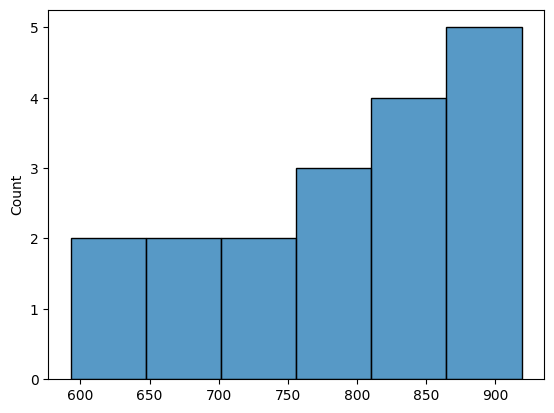

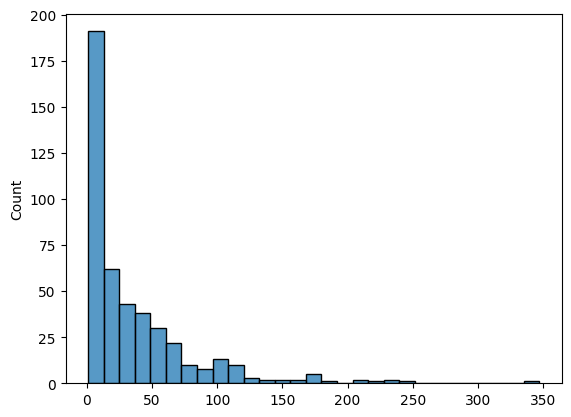

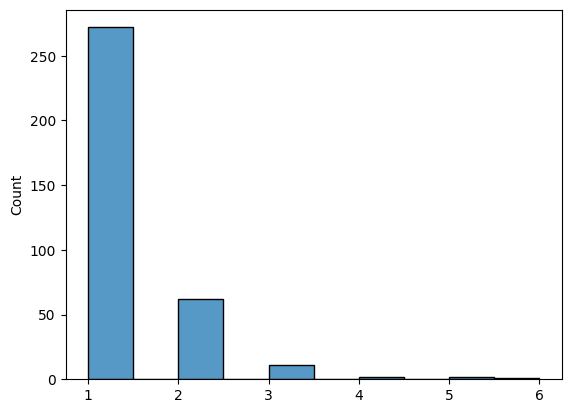

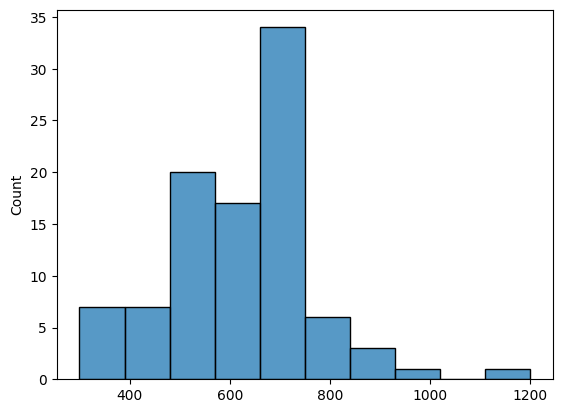

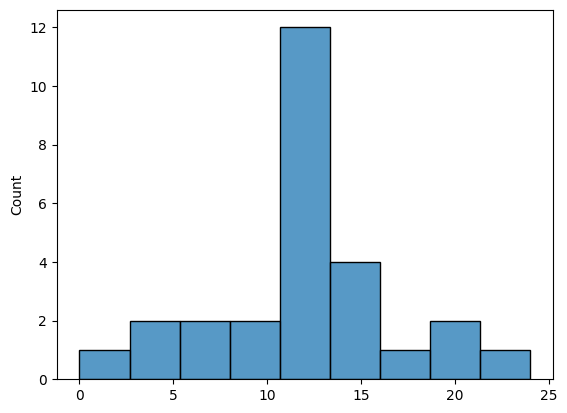

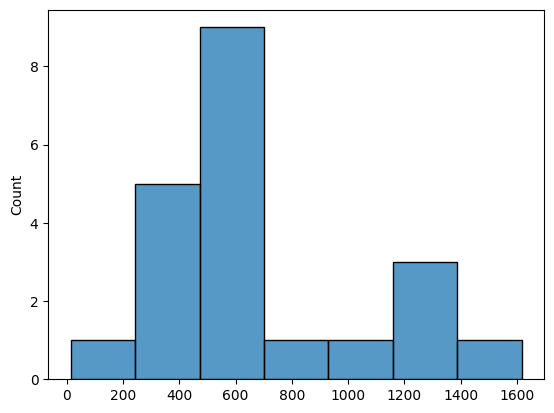

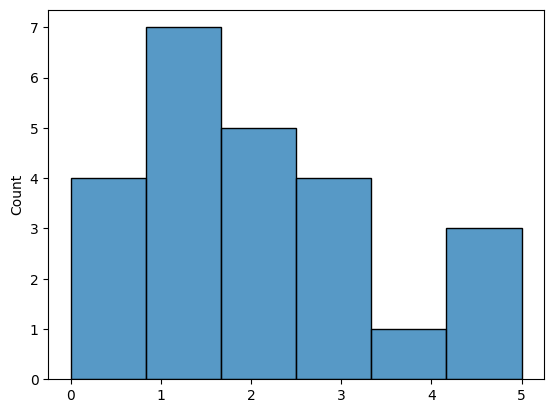

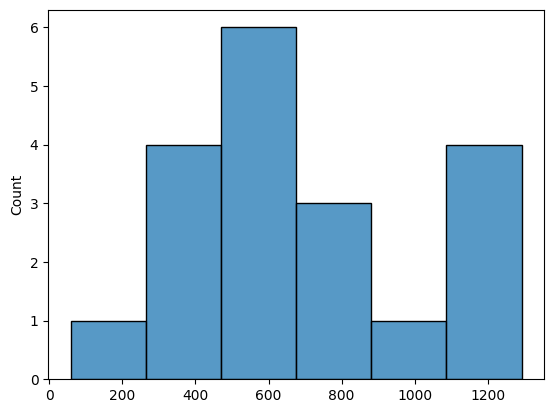

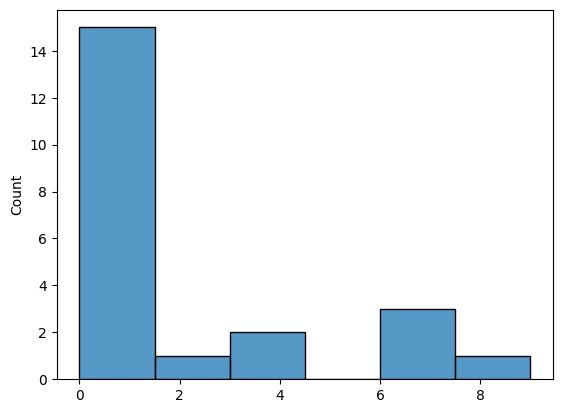

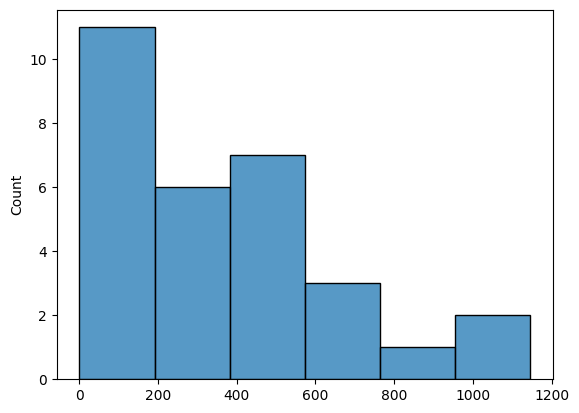

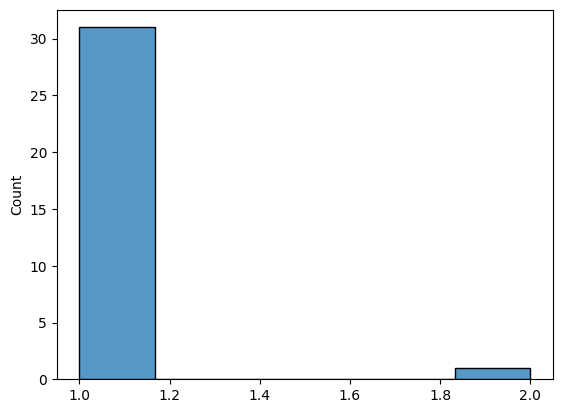

In [65]:
# time_interval = 60 * 10 (10분 고정)
dates = ["1122", "1123", "1128"]

data_dict = dict([(date, 0) for date in dates])
tmp = 0
for date in dates:
    data_dict[date] = preprocess(date)
    tmp = preprocess(date)
    
draw_and_test(pd.concat(data_dict.values()))

In [66]:
period_data = pd.read_excel("data\\5511_배차간격.xlsx")
bus_period_data = []
for i in range(9):
    bus_period_data.extend(period_data.iloc[i, 1:].astype("int64"))
print(apply_test("5511 배차간격", bus_period_data)[2])
draw("5511 총배차간격", bus_period_data)

5511 배차간격의 확률검정
[('norm', 0.06836495908092366), ('gamma', 0.06777606407815773), ('beta', 0.07912084743394932), ('expon', 2.0728822741558803e-06), ('t', 0.06843606507390632), ('chi2', 0.04284808237227855)]
제일 비슷한 분포: beta
그 분포의 p_value: 0.079121
(5.325522182427877, 6.1991583173265905, 2.690141687606122, 16.081948232772902) 



IndexError: tuple index out of range